In [176]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import lazypredict

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [177]:
df_ger = pd.read_csv('Data/Germany.csv',  index_col='Year')
df_ger # the one with categorical variable for Germany

,Country,ISO 3166-1 alpha-3,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
Year,,,,,,,,,,
1850,Germany,DEU,15.139648,15.139648,0.000000,0.000000,0.000000,0.000000,0.000000,0.448635
1851,Germany,DEU,16.869056,16.869056,0.000000,0.000000,0.000000,0.000000,0.000000,0.495347
1852,Germany,DEU,19.173712,19.173712,0.000000,0.000000,0.000000,0.000000,0.000000,0.559163
1853,Germany,DEU,20.760224,20.760224,0.000000,0.000000,0.000000,0.000000,0.000000,0.603109
1854,Germany,DEU,24.365600,24.365600,0.000000,0.000000,0.000000,0.000000,0.000000,0.705615
...,...,...,...,...,...,...,...,...,...,...
2017,Germany,DEU,785.616471,310.763015,279.180926,171.412164,13.408148,2.266922,8.585296,9.508290
2018,Germany,DEU,754.408432,295.673550,265.224228,169.548548,13.227901,2.007493,8.726712,9.100585
2019,Germany,DEU,707.149948,240.086494,270.910415,172.478938,13.286640,2.028361,8.359100,8.504699


In [178]:
# Drop the categorial variables
df= df_ger.select_dtypes(include=['float64'])
df

,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
Year,,,,,,,,
1850,15.139648,15.139648,0.000000,0.000000,0.000000,0.000000,0.000000,0.448635
1851,16.869056,16.869056,0.000000,0.000000,0.000000,0.000000,0.000000,0.495347
1852,19.173712,19.173712,0.000000,0.000000,0.000000,0.000000,0.000000,0.559163
1853,20.760224,20.760224,0.000000,0.000000,0.000000,0.000000,0.000000,0.603109
1854,24.365600,24.365600,0.000000,0.000000,0.000000,0.000000,0.000000,0.705615
...,...,...,...,...,...,...,...,...
2017,785.616471,310.763015,279.180926,171.412164,13.408148,2.266922,8.585296,9.508290
2018,754.408432,295.673550,265.224228,169.548548,13.227901,2.007493,8.726712,9.100585
2019,707.149948,240.086494,270.910415,172.478938,13.286640,2.028361,8.359100,8.504699


In [179]:
#  plot to see total emission versus year for 'Germany'
fig_ger = px.line(df, x=df.index, y="Total")
fig_ger.update_xaxes(rangeslider_visible=True)
fig_ger.show()

Visualize the time series

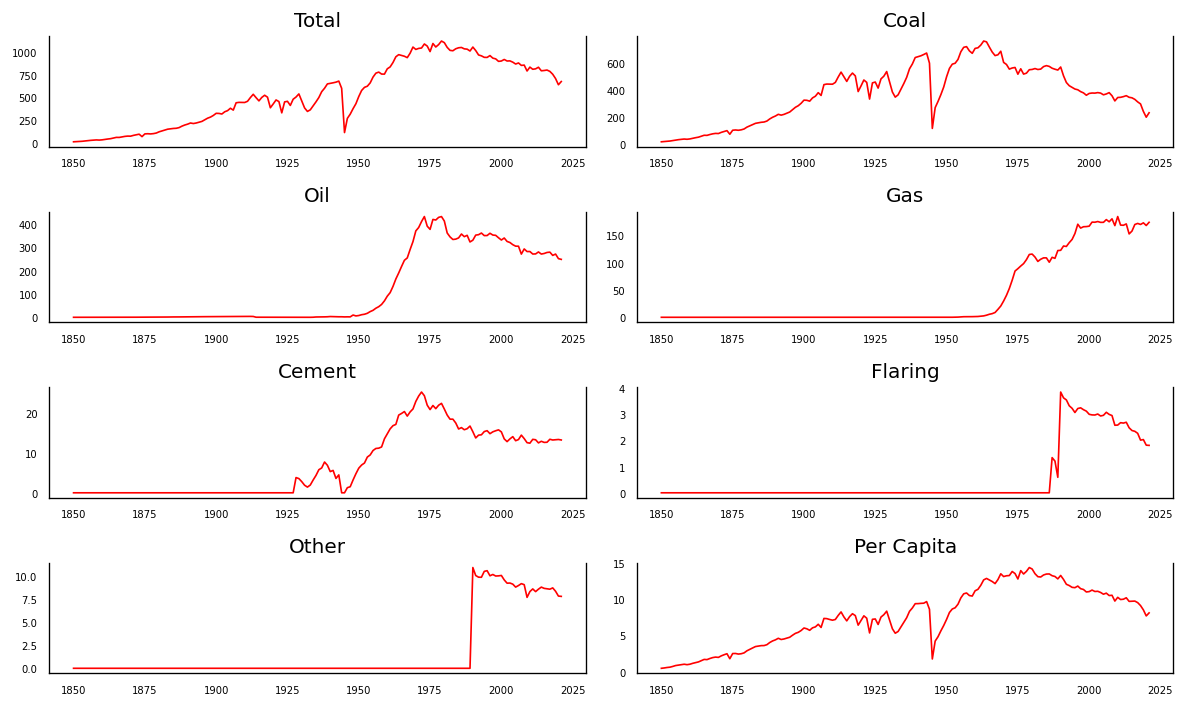

In [180]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

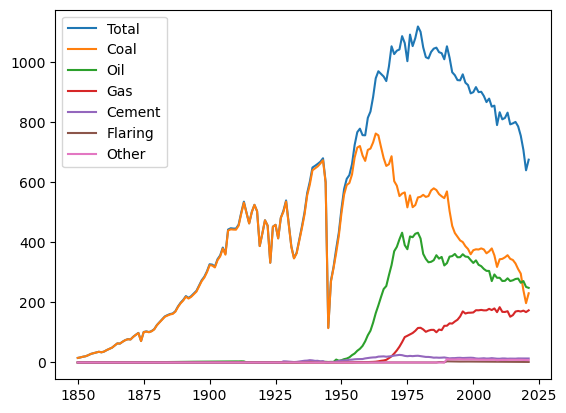

In [181]:
plt.figure()

x = df.index
y1 = df['Total']
y2 = df['Coal']
y3 = df['Oil']
y4 = df['Gas']

y5 = df['Cement']
y6 = df['Flaring']
y7 = df['Other']




plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)

plt.plot(x,y5)
plt.plot(x,y6)
plt.plot(x,y7)



plt.legend(['Total', 'Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other'])

Grainger's Causality Test

In [182]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,Total_x,Coal_x,Oil_x,Gas_x,Cement_x,Flaring_x,Other_x,Per Capita_x
Total_y,1.0000,0.4041,0.4920,0.2026,0.0000,0.1640,0.1599,0.0830
Coal_y,0.2707,1.0000,0.2992,0.1768,0.0000,0.1167,0.1070,0.2710
Oil_y,0.0004,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0008
Gas_y,0.0001,0.0290,0.0000,1.0000,0.0000,0.0000,0.0000,0.0004
Cement_y,0.0084,0.0046,0.0007,0.0176,1.0000,0.3752,0.2792,0.0026
Flaring_y,0.0646,0.3480,0.0000,0.0000,0.0106,1.0000,0.0000,0.0880
Other_y,0.0837,0.4360,0.0000,0.0000,0.0064,0.0000,1.0000,0.1192
Per Capita_y,0.1144,0.4629,0.6181,0.3664,0.0000,0.2330,0.2295,1.0000


 Cointegration Test

In [183]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total  ::  nan       > 143.6691  =>   False
Coal   ::  nan       > 111.7797  =>   False
Oil    ::  129.02    > 83.9383   =>   True
Gas    ::  58.25     > 60.0627   =>   False
Cement ::  32.62     > 40.1749   =>   False
Flaring ::  12.94     > 24.2761   =>   False
Other  ::  1.88      > 12.3212   =>   False
Per Capita ::  -1.83     > 4.1296    =>   False
